In [57]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import easyocr

In [58]:
img = cv2.imread("./data/pvi_cv08_spz.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

<h3>SEGMENTATION</h3>

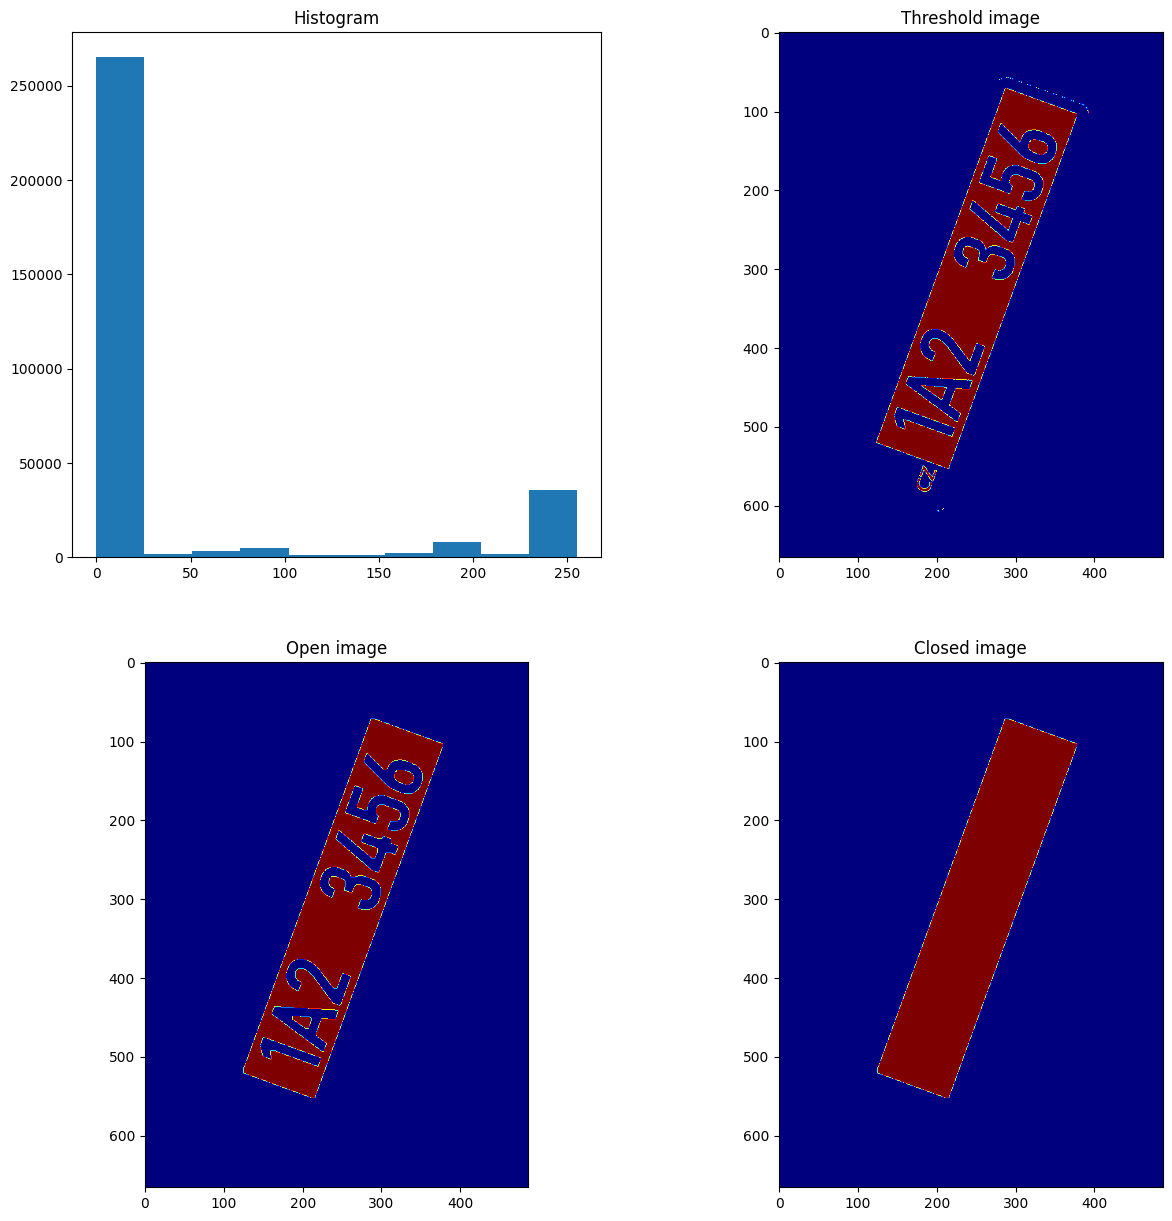

In [59]:
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(2, 2, 1)

# Histogram
plt.hist(img_gray.reshape(-1))
plt.title("Histogram")

# Thresholding
ret, img_thresh = cv2.threshold(img_gray, 220, 255, cv2.THRESH_BINARY)
fig.add_subplot(2, 2, 2)
plt.imshow(img_thresh, cmap="jet")
plt.title("Threshold image")

# Opening + closing
kernel = np.ones((5, 5), np.int8)
img_open = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kernel, iterations=1)
fig.add_subplot(2, 2, 3)
plt.imshow(img_open, cmap="jet")
plt.title("Open image")

img_closed = cv2.morphologyEx(img_open, cv2.MORPH_CLOSE, kernel, iterations=6)
fig.add_subplot(2, 2, 4)
plt.imshow(img_closed, cmap="jet")
plt.title("Closed image")
plt.show()


<h3>CORNER POINTS</h3>

[[ 72 287]
 [ 73 286]
 [ 73 287]
 [103 377]
 [104 377]
 [104 378]
 [521 125]
 [521 126]
 [522 126]
 [552 215]
 [552 216]
 [553 215]]


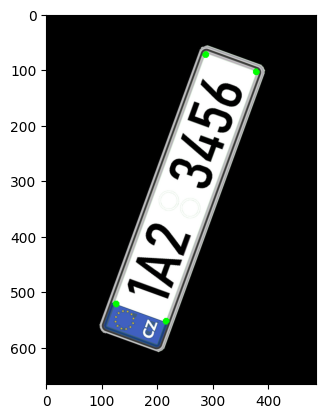

In [60]:
corners = cv2.cornerHarris(img_closed, 2, 3, 0.04)
img_corners = img_rgb.copy()

# Points of the 4 corners
threshold = 0.2 * corners.max()
points = np.argwhere(corners > threshold)
print(points)

for y, x in points:
    cv2.circle(img_corners, (x, y), 3, [0, 255, 0], 4)

plt.imshow(img_corners)


<h3>TILT THE PLATE</h3>

In [61]:
tilt_vector = (int(points[8][1] - points[2][1]), int(points[8][0] - points[2][0]))
alfa = np.arctan(tilt_vector[1] / tilt_vector[0]) * 180 / np.pi

def rotate_image(image, angle, scale):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, scale)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

img_rgb_rotated = rotate_image(img_rgb, alfa, 0.7)
#plt.imshow(img_rgb_rotated)

<h3>RECOGNIZE PLATE NUMBER</h3>

In [62]:
# DEFINE READER
reader = easyocr.Reader(["en"], gpu=False);
text = reader.readtext(img_rgb_rotated)

Using CPU. Note: This module is much faster with a GPU.


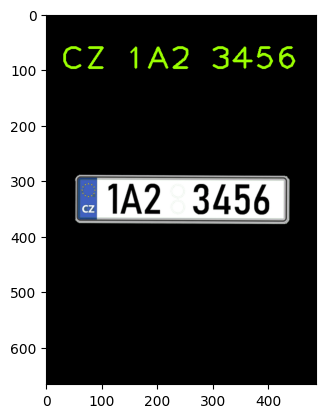

In [63]:
spz_parts = []
for t in text:
    bbox, chars, score = t
    spz_parts.append(chars)

spz = " ".join(spz_parts)

img_rgb_text = cv2.putText(img_rgb_rotated, spz, (25, 100), 1, 4, color=[155, 255, 0], thickness=3)
plt.imshow(img_rgb_text)